# Projet 3 - Préparez des données pour un organisme de santé publique

In [70]:
# Installation des libs
# %pip install pandas numpy scikit-learn matplotlib seaborn
# %pip install skimpy
# %pip install missingno
# %pip install scipy
# %pip install feature-engine
# %pip install plotly
# %pip install mlxtend

In [71]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from skimpy import skim
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from mlxtend.plotting import plot_pca_correlation_graph


%matplotlib inline

# Creations des fonctions utilitaires

## Valeurs manquantes, inutilles ou dupliqué

In [72]:
def delete_useless_duplicate_and_missing_columns(data, useless_columns, threshold,):
    """Deletes columns with more than threshold% of missing values and generates a bar plot showing the remaining columns in the new dataframe.

    Args:
        data (pd.Dataframe): Any dataframe you want to process
        useless_columns(list): A list with all the columns you want to delete
        threshold (int): Threshold percentage of missing values above which columns are deleted

    Returns:
        data (pd.Dataframe):The dataframe with columns removed if they have more than threshold% missing values
    """
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percent = data.isnull().mean() * 100

    # Filtrer les colonnes qui ont plus de threshold% de valeurs manquantes
    cols_with_many_missing = missing_percent[missing_percent > threshold].index
    print(f"Colonnes avec plus de {threshold}% de valeurs manquantes : {len(cols_with_many_missing)}")

    # Supression des colonnes
    data = data.drop(columns = [*cols_with_many_missing , *useless_columns])
    print(f"Colonnes restante apres traitement: {data.shape[1]}")

    # Supression des doublons
    data = data.drop_duplicates()
    return data


## Valeurs aberantes

In [73]:
def identify_and_replace_outliers(data):
    """Identify and replace outliers in the DataFrame.

    This function identifies outliers based on the IQR method and replaces them with NaN.
    It then imputes missing values using KNN for columns with more than 20% missing values
    and uses the median for columns with less than or equal to 20% missing values. Finaly 
    we input categorical data with unknow value.

    Args:
        data (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced and missing values imputed.
    """
    
    # Get numerical columns
    numerical_columns = list(data.select_dtypes(include="number").columns)

    # Calculate the quartiles
    Q1 = data[numerical_columns].quantile(0.25)
    Q3 = data[numerical_columns].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outlier values with NaN
    data[(data[numerical_columns] < lower_bound) | (data[numerical_columns] > upper_bound)] = np.NaN


    # Calculate the percentage of missing values for each column
    missing_percentage = data[numerical_columns].isnull().mean()

    # Columns to impute with KNN (more than 20% missing values)
    columns_knn = missing_percentage[missing_percentage > 0.2].index.tolist()

    # Columns to impute with the median (less than or equal to 20% missing values)
    columns_median = missing_percentage[missing_percentage <= 0.2].index.tolist()

    # Initialize & apply KNN imputer
    knn_imputer = SimpleImputer()
    data[columns_knn] = knn_imputer.fit_transform(data[columns_knn])

    # Replace with the median
    data[columns_median] = data[columns_median].fillna(data[columns_median].median())

    # Handle categorical columns
    categorical_columns = list(data.select_dtypes(include='object').columns)

    # Replace NaN with 'Unknown'
    data[categorical_columns] = data[categorical_columns].fillna('Unknown')

    return data


## Fonctions de visualisations des graphiques

In [74]:

def render_boxplot(data, title, log_scale=False):
    """Render a box plot of the given DataFrame.

    Args:
        data (pd.DataFrame): The data to visualize, with numerical columns.
        title (str): The title of the plot.
        log_scale (bool, optional): If True, use logarithmic scale for y-axis. Defaults to False.
    
    Returns:
        plt.Axes: The Axes object containing the plot.
    """
    
    # Recuperer les variables numeriques
    numerical_columns = data.select_dtypes(include='number').columns
    
    # Cree le plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data[numerical_columns])

    if not title:
        title = ''
    plt.title(title)
    
    # Set y-axis en echelle log si True
    if log_scale:
        plt.yscale('log')

    plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()



def render_heatmap_missing_value(data, title):
    if not title:
        title = 'Heatmap des valeurs manquantes'
        # Faire une Heatmap des valeurs manquantes
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.sample(10_000).isnull(), cmap='plasma', cbar=False, yticklabels=False)
        plt.title(title, fontsize=16)
        plt.show()


def render_correlation_matrix(data, title):
    if not title:
        title = 'Matrice de correlation'
        # Lister les colonnes numerique
        numerical_columns = list(df.select_dtypes(include="number").columns)
        some_array = df[numerical_columns].corr()
        sns.heatmap(some_array, cmap='viridis', annot=True, fmt=".1f")
        plt.title(title, fontsize=16)
        plt.show()

## Fonction generale pour gerer le rendu des graphiques

In [75]:
def generate_graph(data, graph_type, title=None, log_scale=False, cols=[] ):

    # boxplot
    if graph_type == 'boxplot':
        render_boxplot(data, title, log_scale)

    # Heatmap des valeurs manquantes
    if graph_type == 'heatmap':
        render_heatmap_missing_value(data, title)
    
    # Barchart des valeurs manquantes
    if graph_type == 'msno bar':
        msno.bar(data, log=log_scale)

    # Correlation matix
    if graph_type == 'corr':
        render_correlation_matrix(data, title)

# Analyses & Manipulations des données

## Lecture du dataframe

In [76]:
# Lecture du dataframe
df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')

# Faire une copie du dataframe pour garder le dataframe original intact de toute modification
df = df_origin.copy()
df.describe()

C:\Users\vuill\AppData\Local\Temp\ipykernel_7852\1038874156.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')


,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


## Etape 1 - Nettoyez et filtrez des features et produits

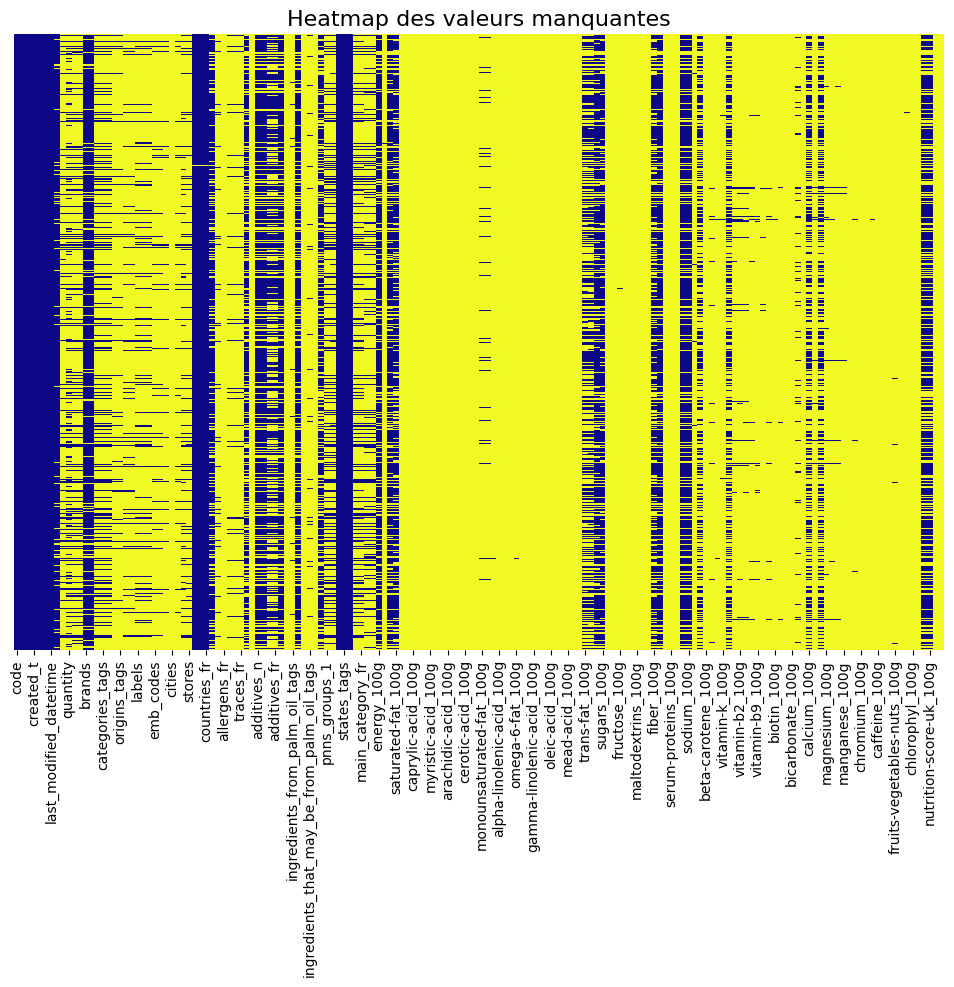

In [77]:
# Affichages des valeurs manquantes
generate_graph(df, 'heatmap')

In [78]:
useless_columns = [
                    'code', 
                    'url', 
                    'creator', 
                    'created_t', 
                    'created_datetime',
                    'last_modified_t', 
                    'last_modified_datetime', 
                    'quantity',
                    'nutrition-score-uk_100g',
                    'countries',
                    'countries_tags',
                    'countries_fr',
                    'ingredients_text',
                    'serving_size',
                    'brands',
                    'brands_tags',
                    'states',
                    'states_fr',
                    'states_tags',
                    'ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n',
                    'additives',                            
                    ]

# Supression des colonnes inutiles, doubles ou avec trop de valeurs manquantes
df = delete_useless_duplicate_and_missing_columns(data=df, useless_columns=useless_columns, threshold=50)

Colonnes avec plus de 50% de valeurs manquantes : 128
Colonnes restante apres traitement: 13


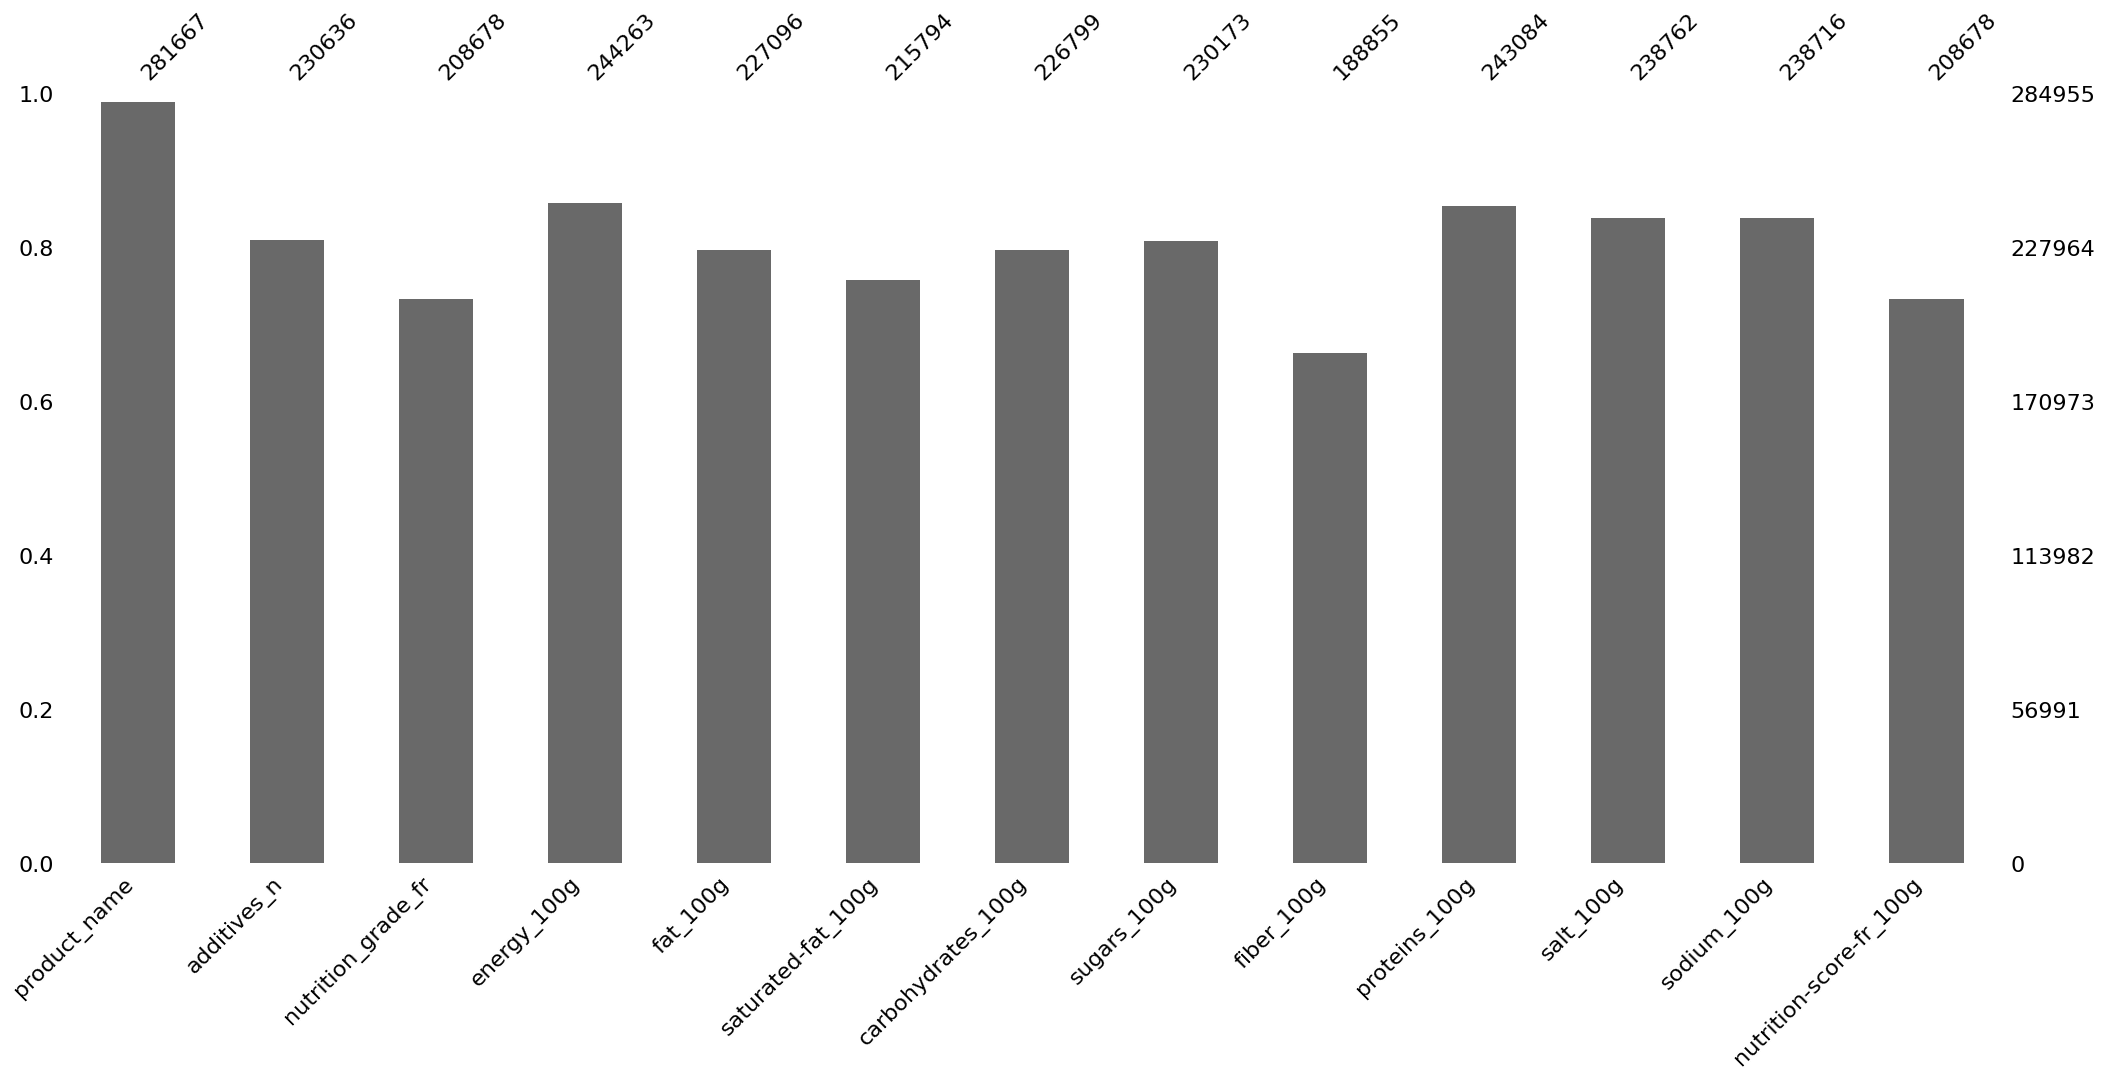

In [79]:
generate_graph(df, 'msno bar')

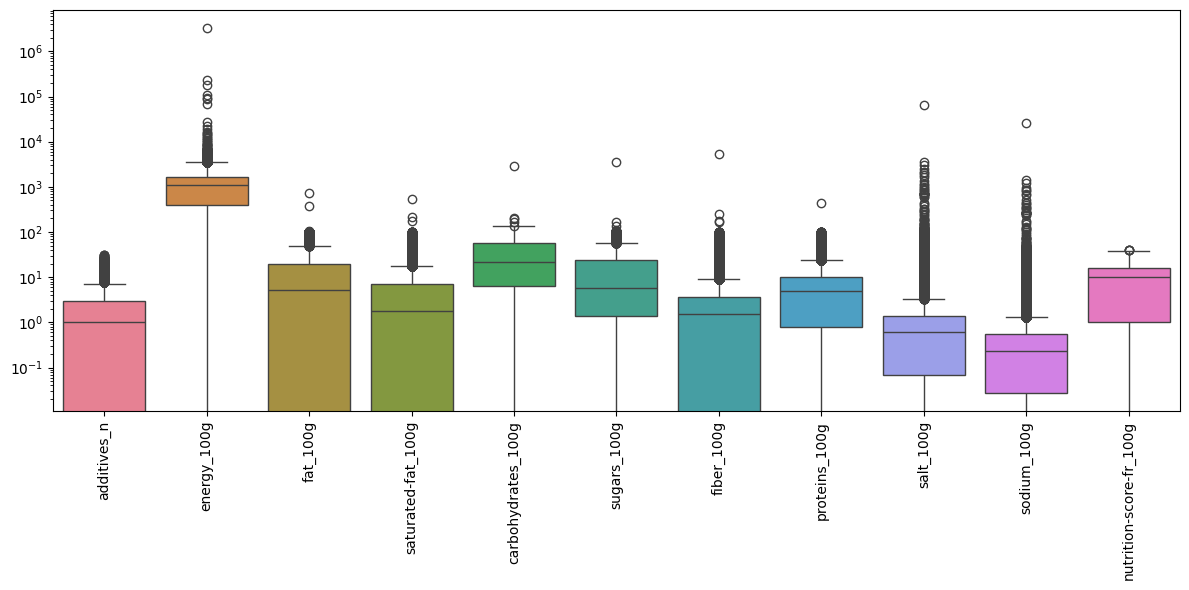

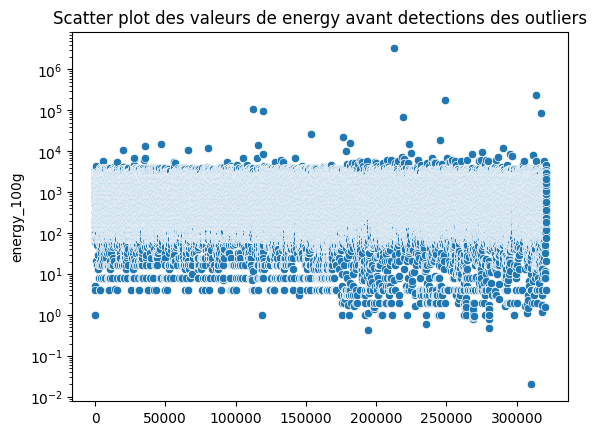

In [80]:
# Identification des valeurs aberrantes (multi variée)
generate_graph(data=df, graph_type='boxplot' ,log_scale=True)

# Scatter PLot de la colonne energy (uni variée)
sns.scatterplot(data=df['energy_100g'])
plt.title('Scatter plot des valeurs de energy avant detections des outliers')
plt.yscale('log')

## Etape 2 - Identifiez et traitez les valeurs aberrantes

In [81]:
# Identification et remplacerment des outliers
df = identify_and_replace_outliers(data=df)

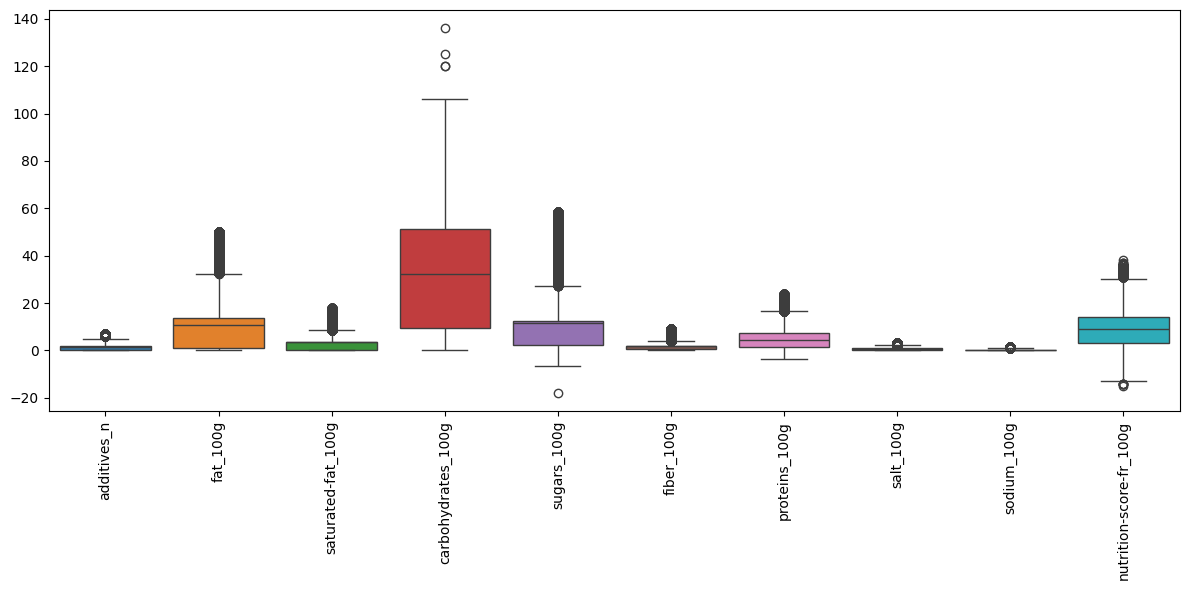

In [82]:
# Visualisations des colonnes après remplacements des valeurs manquantes
generate_graph(data=df.drop('energy_100g', axis=1), graph_type='boxplot' ,log_scale=False)

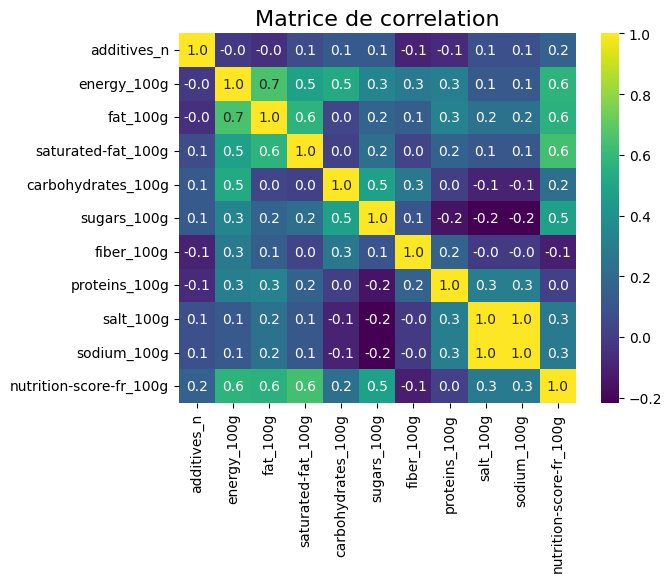

In [83]:
# Matrice de correlations
generate_graph(data=df, graph_type='corr')

# Cecle de correlation (PCA)

In [84]:
def render_pca(data, cols, dimensions):
    figure, correlation_matrix = plot_pca_correlation_graph(data[cols].sample(100_00),                                                         
                                                        cols,
                                                        dimensions=dimensions,
                                                        figure_axis_size=10)
    return None

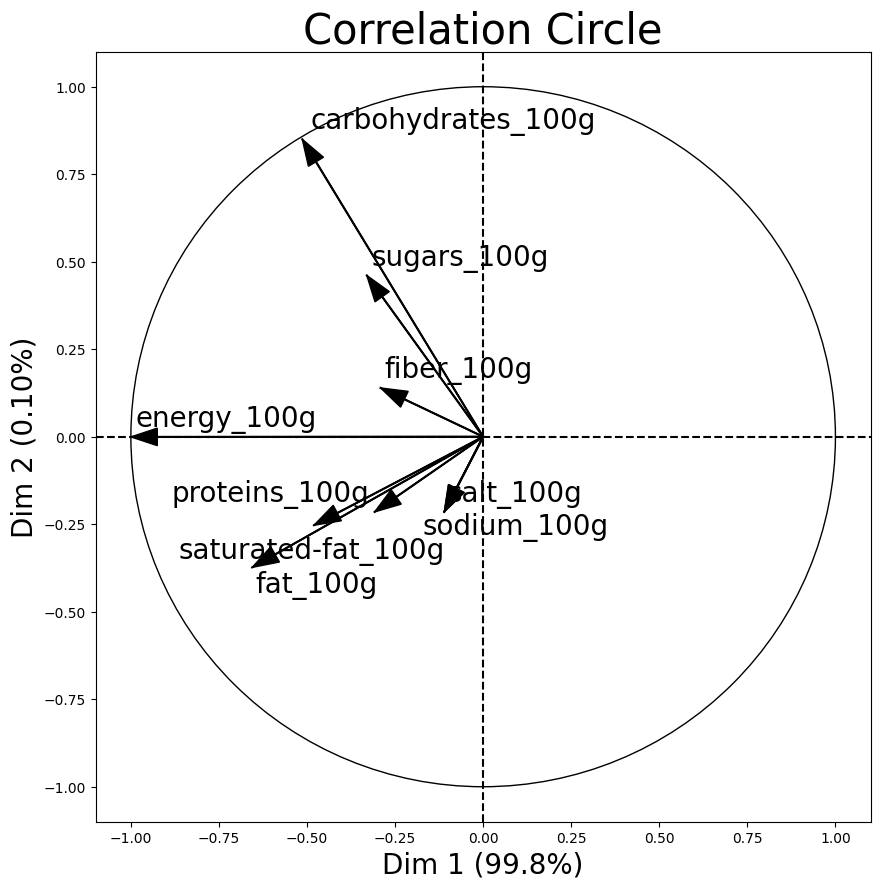

In [85]:
pca_cols = [
            'energy_100g',
            'fat_100g',
            'saturated-fat_100g', 
            'carbohydrates_100g', 
            'sugars_100g', 
            'fiber_100g',
            'proteins_100g', 
            'salt_100g', 
            'sodium_100g',
            ]


render_pca(data=df, cols=pca_cols, dimensions=(1,2))


# ANOVA

In [86]:
def render_anova(df, x, y):
    # Étape 3 : Tracer le boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x, y=y)

    # Étape 4 : Ajouter les lignes min et max pour chaque groupe
    for i, group in enumerate(groups):
        min_value = np.min(group)
        max_value = np.max(group)
        plt.plot([i - 0.2, i + 0.2], [min_value, min_value], color='red', linestyle='--', label='Min' if i == 0 else "")
        plt.plot([i - 0.2, i + 0.2], [max_value, max_value], color='blue', linestyle='--', label='Max' if i == 0 else "")

    # Ajouter des titres et labels
    plt.title('ANOVA des Grades Nutritionnels en fonction de l\'Energie')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.show()


def anova(df, plot, x, y):
    # Recuperations de valeurs numeriques
    numerical_columns = list(df.select_dtypes(include="number").columns)

    # Résultats ANOVA pour chaque colonne numérique
    anova_results = {}
    for col in numerical_columns:
        # Séparer les groupes selon la variable catégorielle
        groups = [df[col][df['nutrition_grade_fr'] == cat] for cat in df['nutrition_grade_fr'].unique()]
        # Appliquer l'ANOVA
        f_val, p_val = stats.f_oneway(*groups)
        anova_results[col] = {'F-value': f_val, 'p-value': p_val}

    if plot:
        render_anova(df, x, y)
        

    # Afficher les résultats
    return anova_results

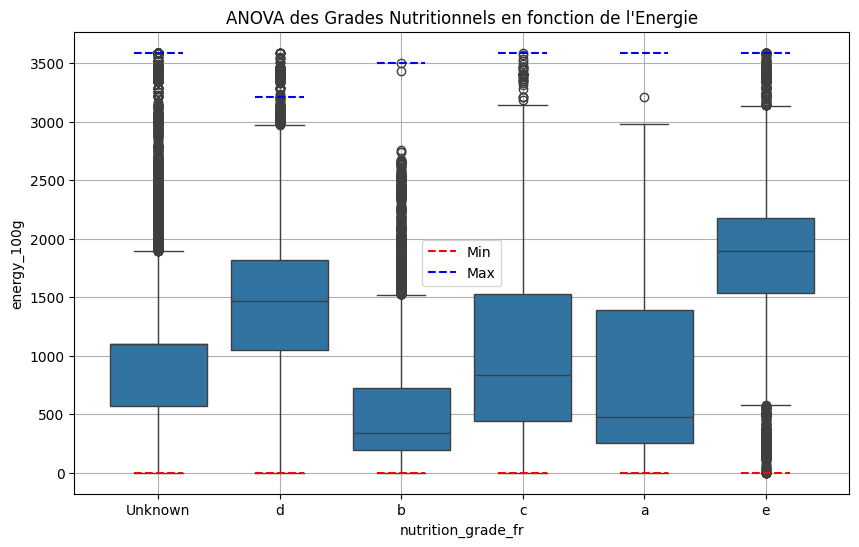

{'additives_n': {'F-value': 1807.6418245961102, 'p-value': 0.0}, 'energy_100g': {'F-value': 27177.32589801125, 'p-value': 0.0}, 'fat_100g': {'F-value': 25938.776721862385, 'p-value': 0.0}, 'saturated-fat_100g': {'F-value': 36089.84431207045, 'p-value': 0.0}, 'carbohydrates_100g': {'F-value': 3985.8543752812257, 'p-value': 0.0}, 'sugars_100g': {'F-value': 13711.987952460382, 'p-value': 0.0}, 'fiber_100g': {'F-value': 2826.916409354878, 'p-value': 0.0}, 'proteins_100g': {'F-value': 4677.510035650294, 'p-value': 0.0}, 'salt_100g': {'F-value': 5905.497752825104, 'p-value': 0.0}, 'sodium_100g': {'F-value': 5902.635672095099, 'p-value': 0.0}, 'nutrition-score-fr_100g': {'F-value': 752268.1027106051, 'p-value': 0.0}}


In [87]:
resultat_anova = anova(df, True, 'nutrition_grade_fr', 'energy_100g')
print(resultat_anova)

L'analyse de variance (ANOVA) réalisée sur les différentes variables numériques en fonction de la variable catégorielle révèle des résultats significatifs dans tous les cas examinés. Les valeurs F élevées, allant de 306.51 à 335269.58, indiquent que la variance entre les groupes est bien supérieure à la variance au sein des groupes, suggérant des différences marquées dans les moyennes des groupes pour chacune des variables.

De plus, les p-values égales à 0.0 pour toutes les variables analysées indiquent que les différences observées sont statistiquement significatives. Cela signifie que la variable catégorielle a un impact important sur chaque mesure numérique, justifiant ainsi l'importance de la prise en compte de cette variable lors de l'analyse des données.

Les variables relatives aux nutriments tels que nutrition-score-fr_100g et nutrition-score-uk_100g affichent les valeurs F les plus élevées, ce qui pourrait suggérer des disparités significatives dans la qualité nutritionnelle des produits étudiés. Les résultats mettent en évidence des différences claires dans les teneurs en additifs, graisses, sucres, et autres composants, ce qui peut avoir des implications importantes pour les décisions réglementaires, les recommandations de consommation et les stratégies de formulation des produits.

Dans l'ensemble, cette analyse souligne l'importance d'explorer les effets des facteurs catégoriels sur les caractéristiques numériques dans des études de nutrition et de santé publique.